# 🧼 Prétraitement des données brutes Fiverr

Ce notebook correspond à la phase de **pré-processing** du dataset Fiverr téléchargé via Kaggle. Il prépare les données brutes à des fins d’analyse ou de modélisation, en appliquant un nettoyage et une structuration adaptés.

## 🎯 Objectifs
- Analyser la structure initiale du fichier
- Supprimer les colonnes non pertinentes ou vides
- Nettoyer les chaînes de caractères et corriger les valeurs incohérentes
- Convertir les types de données (ex. : `Price`, `Rating`)
- Exporter un fichier prêt à l’analyse : `fiverr-data-gigs-cleaned.csv`

✅ **Compétences mobilisées :**  
- Bloc 3 — C2 : Préparer les données pour l’analyse  
- Bloc 5 — C1 : Préparer des données non structurées
---

## 📦 Import des bibliothèques nécessaires

Ce notebook utilise les bibliothèques suivantes pour manipuler, nettoyer et explorer les données.

### 📚 Choix des bibliothèques et justification

- **`pandas`** : bibliothèque incontournable pour manipuler des données tabulaires (lecture/écriture de fichiers, nettoyage, filtrage, transformation des colonnes).
- **`numpy`** : utile pour les conversions de types numériques, le traitement vectoriel et la gestion des valeurs manquantes.
- **`matplotlib.pyplot`** : permet de tracer des graphiques de base (histogrammes, courbes, nuages de points).
- **`seaborn`** : bibliothèque de visualisation basée sur `matplotlib`, adaptée pour créer rapidement des graphiques statistiques élégants (distribution, corrélations, regroupements).
- **`re`** : module natif Python pour le traitement des chaînes de caractères avec des expressions régulières (extraction d’information, nettoyage).

Ces outils couvrent l’ensemble des besoins pour le **prétraitement** et la **visualisation exploratoire** des données brutes.


In [87]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import kagglehub
import shutil
import os
from tqdm.auto import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import KNNImputer

## 🌐 Téléchargement automatique des données depuis Kaggle

Avant de commencer le nettoyage ou toute autre transformation, nous allons **automatiser le téléchargement du dataset** directement depuis Kaggle via l’API `kagglehub`.  
Cela garantit que nous utilisons toujours la version la plus récente du jeu de données, tout en facilitant la reproductibilité du pipeline.

### Pourquoi automatiser cette étape ?
- Évite d’avoir à télécharger manuellement le fichier CSV.
- Assure une **traçabilité** et une **mise à jour régulière** des données.
- S’intègre parfaitement dans un pipeline complet (local, cloud ou CI/CD).

### Résultat attendu
- Le dossier contenant les fichiers du dataset est automatiquement créé.
- Le chemin absolu est stocké dans la variable `path`.
- On peut ensuite s’en servir pour charger le fichier `.csv` dans un `DataFrame`.

In [88]:
# Téléchargement de la dernière version du dataset Fiverr depuis Kaggle

# 1. Télécharger le dataset depuis Kaggle (dans le cache local)
cache_path = kagglehub.dataset_download("muhammadadiltalay/fiverr-data-gigs")

# 2. Spécifier le chemin cible dans ton projet
target_path = os.path.join("data", "fiverr_gigs")

# 3. Créer le dossier s’il n’existe pas déjà
os.makedirs(target_path, exist_ok=True)

# 4. Copier tous les fichiers du dossier cache vers le dossier du projet
for filename in os.listdir(cache_path):
    source_file = os.path.join(cache_path, filename)
    target_file = os.path.join(target_path, filename)
    shutil.copy2(source_file, target_file)

print("Path to dataset files:", cache_path)
print(f"✅ Dataset copié dans le dossier du projet : {target_path}")

Path to dataset files: C:\Users\lfoll\.cache\kagglehub\datasets\muhammadadiltalay\fiverr-data-gigs\versions\1
✅ Dataset copié dans le dossier du projet : data\fiverr_gigs


## 📂 Chargement des données brutes Fiverr

Cette étape consiste à **importer les données brutes** directement depuis le fichier CSV d’origine téléchargé depuis Kaggle.  
Ces données n’ont subi **aucun nettoyage** pour le moment : elles contiennent potentiellement des erreurs d’encodage, des caractères spéciaux, des doublons ou des types de colonnes incorrects.

### Pourquoi cette étape maintenant ?
- C’est le **point de départ** de tout pipeline de data science ou de machine learning : avant d’analyser ou modéliser, il faut charger les données brutes.
- Cela permet de **détecter rapidement les anomalies structurelles** du fichier (encodage, noms de colonnes, valeurs manquantes).
- Elle précède les étapes de nettoyage, transformation ou vectorisation, car celles-ci ne peuvent être appliquées que sur un DataFrame déjà chargé en mémoire.

### Résultat attendu
- Création d’un objet `df` de type `DataFrame`, représentant les données brutes.
- Possibilité de visualiser les premières lignes pour **valider que le chargement a réussi** (pas de plantage d’encodage, pas de colonnes manquantes).
- Étape indispensable pour enclencher un pipeline de **pré-processing propre et robuste**.

In [89]:
# Chargement du fichier CSV dans un DataFrame pandas

df = pd.read_csv(
    'data/fiverr_gigs/fiverr-data-gigs.csv',    # Chemin relatif vers le fichier de données
    encoding='UTF-8',                         # Utilisé pour décoder les caractères spéciaux (utile si UTF-8 génère des erreurs, fréquent avec des accents)
    low_memory=False                            # Force pandas à lire tout le fichier avant de deviner les types de colonnes (évite les avertissements ou erreurs)
)

# Affiche les 10 premières lignes du DataFrame pour en examiner un aperçu
df.head(2)

,Title,Title_URL,gigrating,_5fo9i5,Price
0,"I will do excel formulas, vba macros, charts, ...",https://www.fiverr.com/maltehar/do-excel-formu...,5.0(56),Level 2 Seller,"PKR 8,701"
1,"I will do data mining, web scraping, data extr...",https://www.fiverr.com/hotopilams/do-data-mini...,5.0(1k+),Top Rated Seller,"PKR 3,263"


## 🧪 Analyse exploratoire initiale du dataset

Avant d'appliquer un quelconque prétraitement, il est essentiel de **comprendre la structure et la qualité** des données brutes. Cette étape permet de détecter :
- les **valeurs manquantes** ou mal formatées,
- les **types de données** incorrects,
- les **données dupliquées**,
- ou encore les **colonnes peu informatives**.

### 🔍 Pourquoi cette étape maintenant ?
- C’est une **étape préliminaire de diagnostic**, qui permet d’ajuster les étapes de nettoyage à suivre.
- Elle donne un aperçu clair de **l’état réel** du fichier importé.
- Elle évite d’effectuer un traitement inutile ou de rater des incohérences.

### 🧰 Ce que nous analysons :
- Dimensions du dataset (lignes, colonnes)
- Un aperçu visuel des premières lignes
- Types de données (object, float, int…)
- Pourcentage de valeurs manquantes par colonne
- Statistiques descriptives sur les variables numériques
- Nombre de valeurs uniques par colonne
- Nombre de doublons

In [ ]:
# Aperçu rapide du dataset
print("Dimensions du dataset :", df.shape)
display(df.head())

# Types de données
print("\nTypes de données :")
print(df.dtypes)

# Pourcentage de valeurs manquantes par colonne
print("\n🔍 Pourcentage de valeurs manquantes :")
missing_percent = df.isnull().mean() * 100
print(missing_percent.sort_values(ascending=False))

# Statistiques descriptives des colonnes numériques
print("\n📊 Statistiques descriptives (numériques uniquement) :")
display(df.describe())

# Valeurs uniques par colonne (utile pour détecter des colonnes constantes ou presque)
print("\n🔁 Nombre de valeurs uniques par colonne :")
print(df.nunique().sort_values())

# Doublons éventuels
print(f"\n🧬 Nombre de lignes dupliquées : {df.duplicated().sum()}")


## 🌡️ Visualisation des valeurs manquantes

Même si les pourcentages de valeurs manquantes sont utiles, une **visualisation graphique** permet souvent de mieux détecter :
- la **distribution** des valeurs manquantes dans les colonnes,
- l’éventuelle **concentration par ligne** (ex. : données mal extraites),
- et les colonnes à traiter en priorité (ex. : valeurs manquantes massives).

---

### 🎯 Objectif :
Mettre en évidence, via une **carte thermique**, les cellules contenant des `NaN` dans notre DataFrame.

In [ ]:
plt.figure(figsize=(12, 5))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title('🌡️ Carte des valeurs manquantes dans le dataset')
plt.xlabel("Colonnes")
plt.ylabel("Lignes")
plt.show()

In [ ]:
missing_percent = df.isnull().mean() * 100
missing_percent = missing_percent[missing_percent > 0].sort_values(ascending=False)

plt.figure(figsize=(10, 5))
sns.barplot(x=missing_percent.values, y=missing_percent.index, palette="Reds_r")
plt.title("📉 Pourcentage de valeurs manquantes par colonne")
plt.xlabel("Pourcentage (%)")
plt.ylabel("Colonnes")
plt.show()


In [ ]:
numeric_cols = ['Price', 'Rating_Score', 'Rating_Count']

plt.figure(figsize=(12, 5))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(1, 3, i)
    sns.boxplot(data=df, y=col, color="skyblue")
    plt.title(f"📦 Outliers dans {col}")
plt.tight_layout()
plt.show()


In [ ]:
df[numeric_cols].hist(bins=30, figsize=(12, 6), color='steelblue', edgecolor='black')
plt.suptitle("📈 Distribution des variables numériques")
plt.show()


In [ ]:
plt.figure(figsize=(8, 4))
sns.countplot(data=df, y='Level', order=df['Level'].value_counts().index, palette='Set2')
plt.title("📋 Répartition des niveaux de vendeur (Level)")
plt.xlabel("Nombre de gigs")
plt.ylabel("Niveau")
plt.show()


## 🏷️ Renommage de la colonne "Level"

In [90]:
df.rename(columns={'_5fo9i5': 'Level'}, inplace=True)
print("Colonnes :", df.columns.tolist())

Colonnes : ['Title', 'Title_URL', 'gigrating', 'Level', 'Price']


## 💰 Nettoyage de la colonne 'Price'
### Étapes :
1. Supprimer les caractères non numériques (lettres, devises, espaces, caractères spéciaux)
2. Remplacer les virgules par des points les séparateurs de milliers ','
3. Convertir en float

In [91]:
df['Price'] = (
    df['Price']
    .astype(str)
    .str.replace(r'[^\d,]', '', regex=True)      # Garde seulement chiffres et virgule
    .str.replace(',', '.', regex=False)          # Transforme la virgule en point
    .str.replace(r'\.(?=.*\.)', '', regex=True)   # Supprime tous les points sauf le dernier
    .replace('', np.nan)                          # Gère les cellules vides
    .astype(float)                                # Conversion en float
)

# Vérification
print(df['Price'].head())


0    8.701
1    3.263
2    2.176
3    1.088
4    4.351
Name: Price, dtype: float64


## ⭐ Extraction des notes et du nombre d'évaluations

In [92]:
df['Rating_Score'] = df['gigrating'].str.extract(r'^([\d.]+)').astype(float)

def parse_review_count(s):
    if pd.isna(s): return np.nan
    match = re.search(r'\(([^)]+)\)', s)
    if not match: return np.nan
    val = match.group(1).lower().replace('+', '')
    if 'k' in val:
        return float(val.replace('k', '')) * 1000
    return float(val)

df['Rating_Count'] = df['gigrating'].apply(parse_review_count)


## 🧠 Imputation des valeurs manquantes dans la colonne `Price`

Après avoir converti proprement la colonne `Price` en `float`, certaines cellules peuvent rester vides (`NaN`) si le nettoyage a supprimé des caractères incohérents ou si la donnée était absente dans le fichier d’origine.

### Pourquoi cette étape est importante ?
- Les **valeurs manquantes** empêchent certaines opérations (modélisation, statistiques).
- Remplacer arbitrairement ces valeurs (par 0 ou une moyenne globale) peut fausser les résultats.
- L’imputation par les **K plus proches voisins (KNN)** permet d’estimer une valeur réaliste à partir d’observations similaires dans les autres colonnes numériques (par exemple, la note et le nombre d’évaluations).

### Méthode utilisée :
- `KNNImputer` de `sklearn.impute` : calcule une estimation en se basant sur les 5 enregistrements les plus proches (paramètre `n_neighbors=5`).
- On utilise les colonnes numériques pertinentes pour guider l’imputation : `Price`, `Rating_Score`, et `Rating_Count`.

### Résultat attendu :
- Toutes les cellules `NaN` de la colonne `Price` sont remplacées par une **valeur cohérente** avec les autres colonnes du gig.
- Le DataFrame est prêt à être utilisé pour la suite du traitement ou l’entraînement d’un modèle.

In [93]:
# Sélection des colonnes numériques utiles pour l’imputation
cols_for_impute = ['Price', 'Rating_Score', 'Rating_Count']

# Copie temporaire du DataFrame pour imputation
df_impute = df[cols_for_impute].copy()

# Initialisation de l’imputer KNN (ici avec k=5 voisins)
imputer = KNNImputer(n_neighbors=5)

# Application de l’imputation
df_imputed = imputer.fit_transform(df_impute)

# Remplacement des anciennes valeurs dans df
df[cols_for_impute] = df_imputed

## 🤖 Imputation des valeurs manquantes dans la colonne "Level" avec KNN

La colonne **`Level`** contient de nombreuses valeurs manquantes (`NaN`). Plutôt que de les supprimer ou les remplacer par une valeur arbitraire, nous utilisons ici une méthode **d’imputation par les K plus proches voisins** (`KNNImputer`) pour estimer la valeur la plus probable selon les autres caractéristiques du vendeur (prix, note, nombre d’évaluations).

### 🔎 Pourquoi ce choix ?
- `Level` est une variable **catégorielle ordonnée** (ex. "Level 1", "Top Rated Seller", etc.).
- `KNNImputer` fonctionne uniquement sur des données **numériques** → nous devons encoder `Level`.
- Cette approche permet une **imputation contextuelle** : deux vendeurs proches sur les critères objectifs auront probablement un niveau similaire.

### 🛠️ Étapes appliquées :
1. **Encodage** de `Level` avec `LabelEncoder` (valeurs numériques temporaires).
2. **Sélection des colonnes numériques pertinentes** : `Price`, `Rating_Score`, `Rating_Count`, `Level_encoded`.
3. **Application du KNNImputer** avec `k = 5`.
4. **Décodage inverse** pour retrouver les labels initiaux.
5. **Nettoyage de la colonne temporaire.`


In [94]:
# Étape 1 : Encodage temporaire des valeurs de "Level"
le = LabelEncoder()
df['Level_encoded'] = pd.Series(dtype='float')  # Prépare la colonne

# On encode uniquement les valeurs non nulles
non_null_mask = df['Level'].notnull()
df.loc[non_null_mask, 'Level_encoded'] = le.fit_transform(df.loc[non_null_mask, 'Level'])

# Étape 2 : Préparer les colonnes pour KNN
cols_for_knn = ['Price', 'Rating_Score', 'Rating_Count', 'Level_encoded']
df_knn = df[cols_for_knn].copy()

# Étape 3 : Imputation KNN
imputer = KNNImputer(n_neighbors=5)
df_imputed = imputer.fit_transform(df_knn)

# Remplacement dans le DataFrame
df_knn_imputed = pd.DataFrame(df_imputed, columns=cols_for_knn)

# Étape 4 : Remplacer dans df final
df['Level_encoded'] = df_knn_imputed['Level_encoded'].round().astype(int)
df['Level'] = le.inverse_transform(df['Level_encoded'])

# Optionnel : suppression de la colonne temporaire
df.drop(columns='Level_encoded', inplace=True)


## 🗑️ Suppression de la colonne 'Rating' d'origine

In [95]:
df.drop(columns=['gigrating'], inplace=True)
df.head(2)

,Title,Title_URL,Level,Price,Rating_Score,Rating_Count
0,"I will do excel formulas, vba macros, charts, ...",https://www.fiverr.com/maltehar/do-excel-formu...,Level 2 Seller,8.701,5.0,56.0
1,"I will do data mining, web scraping, data extr...",https://www.fiverr.com/hotopilams/do-data-mini...,Top Rated Seller,3.263,5.0,1000.0


## ✏️ Nettoyage des chaînes de caractères

In [96]:
# Suppression des espaces superflus sur toutes les colonnes de type texte
for col in df.select_dtypes(include='object').columns:
    df[col] = df[col].astype(str).str.strip()

## 👀 Aperçu des données nettoyées

In [97]:
df.head(2)

,Title,Title_URL,Level,Price,Rating_Score,Rating_Count
0,"I will do excel formulas, vba macros, charts, ...",https://www.fiverr.com/maltehar/do-excel-formu...,Level 2 Seller,8.701,5.0,56.0
1,"I will do data mining, web scraping, data extr...",https://www.fiverr.com/hotopilams/do-data-mini...,Top Rated Seller,3.263,5.0,1000.0


## 📊 Statistiques descriptives

In [98]:
df.describe()

,Price,Rating_Score,Rating_Count
count,1259.000000,1259.000000,1259.000000
mean,14.993086,4.965020,79.373471
std,70.785249,0.134617,137.857219
min,1.088000,1.000000,1.000000
25%,2.176000,4.980000,15.000000
50%,4.351000,5.000000,32.000000
75%,10.876000,5.000000,76.600000
max,2175.105000,5.000000,1000.000000


## 📈 Visualisation des distributions

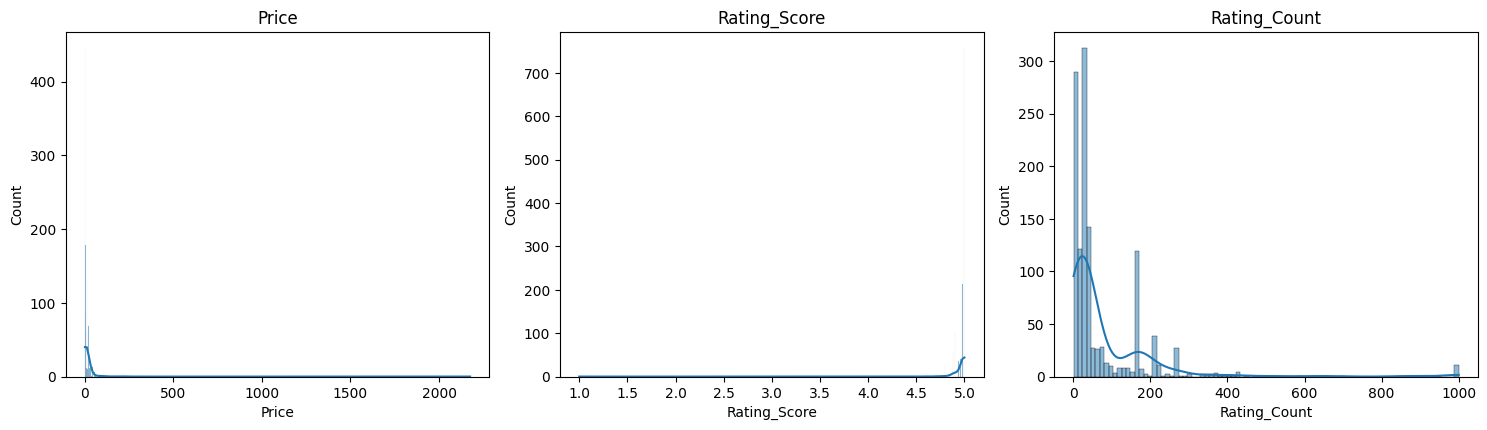

In [99]:
numerical_cols = df.select_dtypes(include=['float64', 'int']).columns

plt.figure(figsize=(15, 8))
for i, col in enumerate(numerical_cols):
    plt.subplot(2, 3, i + 1)
    sns.histplot(df[col].dropna(), kde=True)
    plt.title(col)
plt.tight_layout()
plt.show()


## 💾 Export du fichier nettoyé

In [100]:
df.to_csv('data/fiverr_gigs/fiverr-data-gigs-cleaned.csv', index=False, encoding='utf-8')
print("✅ Données exportées dans 'data/fiverr_gigs/fiverr-data-gigs-cleaned.csv'")

✅ Données exportées dans 'data/fiverr_gigs/fiverr-data-gigs-cleaned.csv'
